In [3]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation, Dropout
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB



In [6]:
df_train = pd.read_csv('./data/clean_train.csv')
df_test = pd.read_csv('./data/clean_test.csv')

In [7]:
def cleaner(dataframe, name):
    df = pd.DataFrame(dataframe.values, columns = [i.lower() for i in dataframe.columns])
    df['ltv'].apply(lambda i: i/100) # convert ltv to percentage
    
    # nulls in employment indicate 'no history available'
    # fillna with -1, OHE for [Salaried : Self-employed : no employment history available]
    df.fillna(-1, inplace = True)
    df['employment_self'] = df['employment_type'].map(lambda i: 1 if i =='Self employed' else 0)
    df['employment_none'] = df['employment_type'].map(lambda i: 1 if i == -1 else 0)
    
    # convert string DD-MM-YYYY to datetime
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], dayfirst = True)
    df['disbursal_date'] = pd.to_datetime(df['disbursal_date'], dayfirst = True)
    df['age_at_disbursal'] = df['disbursal_date'].dt.year - df['date_of_birth'].dt.year
    
    # convert @yrs &mon string to int (@*12 + &) months
    df['average_acct_age_months'] = (df['average_acct_age'].str.extract("(\d+)yrs", expand=False).astype(int) * 12
                                     + df['average_acct_age'].str.extract("(\d+)mon", expand=False).astype(int))
    
    df['credit_history_length_months'] = (df['credit_history_length'].str.extract("(\d+)yrs", expand=False).astype(int) * 12
                                                + df['credit_history_length'].str.extract("(\d+)mon", expand=False).astype(int))
    
    # convert to ordinal scale
    df['cns_score_category'] = df['perform_cns_score_description'].map({'A-Very Low Risk': 1,
                                         'B-Very Low Risk': 2,
                                         'C-Very Low Risk': 3,
                                         'D-Very Low Risk': 4,
                                         'E-Low Risk': 5,
                                         'F-Low Risk': 6,
                                         'G-Low Risk':7 ,
                                         'H-Medium Risk': 8,
                                         'I-Medium Risk': 9,
                                         'J-High Risk': 10,
                                         'K-High Risk': 11,
                                         'L-Very High Risk': 12,
                                         'M-Very High Risk': 13,
                                         'No Bureau History Available': 0,
                                         'Not Scored: More than 50 active Accounts found': 0,
                                         'Not Scored: No Activity seen on the customer (Inactive)': 0,
                                         'Not Scored: No Updates available in last 36 months': 0,
                                         'Not Scored: Not Enough Info available on the customer': 0,
                                         'Not Scored: Only a Guarantor': 0,
                                         'Not Scored: Sufficient History Not Available': 0})
    # binary column for 'not scored due to unreliable history information'
    # in contrast with 'No bureau history information available' which is 0 on cns_score
    # 'not scored' are low but non-zero cns_score
    df['cns_score_unreliable'] = df['perform_cns_score_description'].map(lambda i: 1 if 'Not Scored:' in i else 0)
    
    # recast to int
    if 'loan_default' in df.columns:
        df['loan_default'] = df['loan_default'].astype(int)

    #df_train['DATE_OF_BIRTH'] = pd.to_datetime(df_train['DATE_OF_BIRTH'], format='%d-%m-%Y')
    #df_train['DATE_OF_BIRTH'] = df_train['DATE_OF_BIRTH'].dt.year
    #df_train['DATE_OF_BIRTH'] = df_train['DATE_OF_BIRTH'].astype(int)

    
    # drop 
    df.drop(columns = ['employment_type','date_of_birth','disbursal_date', 'average_acct_age', 'credit_history_length', 'perform_cns_score_description', 'uniqueid', 'supplier_id', 'manufacturer_id', 'current_pincode_id', 'state_id'], inplace = True)
    
    # save cleaned df to local
    df.to_csv(f'clean_{name}.csv', index = False)

In [4]:
cleaner(df_train, 'train')
cleaner(df_test, 'test')

In [9]:
# df_train = pd.read_csv('clean_train.csv')

df_train = pd.read_csv('./data/trained_sample.csv')
df_test = pd.read_csv('./data/clean_test.csv')

In [10]:
# X = df_train.drop("loan_default", axis=1)
features = ['disbursed_amount_treated', 'pri_active_accts',  'pri_overdue_accts', 'sec_active_accts', 'sec_overdue_accts',
            'sec_current_balance', 'perform_cns_score', 'no_of_inquiries', 'age_at_disbursal', 'cns_score_unreliable',
            'credit_history_length_months', 'primary_instal_amt', 'sec_instal_amt', 'loan_default']

X = df_train[features]
y = df_train["loan_default"]

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

In [13]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [14]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [15]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [16]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

0.8724424114601879
0.8697220628023284
0.8749828159797641
0.872344508100107


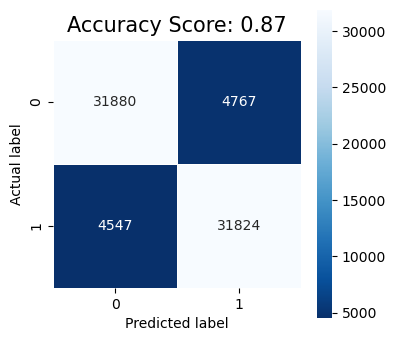

In [27]:
# Logistic Regression
logreg_y_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_y_pred)
logreg_precision = precision_score(y_test, logreg_y_pred)
logreg_recall = recall_score(y_test, logreg_y_pred)
logreg_f1 = f1_score(y_test, logreg_y_pred)

logreg_y_pred = logreg.predict(X_test)
logreg_cm = confusion_matrix(y_test, logreg_y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(logreg_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.2f}'.format(logreg_acc)
plt.title(all_sample_title, size = 15);
plt.savefig('./visuals/cf_lr.png')

print(logreg_acc)
print(logreg_precision)
print(logreg_recall)
print(logreg_f1)

0.9831137527732888
0.982877088830255
0.9832283962497594
0.9830527111538725


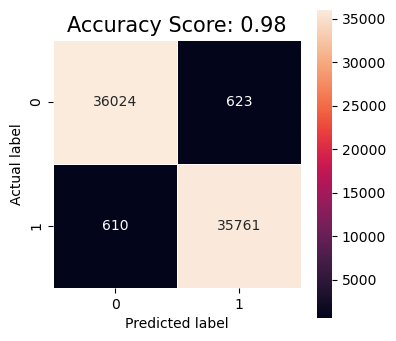

In [26]:
# Decision Tree
dt_y_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_f1 = f1_score(y_test, dt_y_pred)

dt_cm = confusion_matrix(y_test, dt_y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(dt_cm, annot=True, fmt=".0f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.2f}'.format(dt_acc)
plt.title(all_sample_title, size = 15);
plt.savefig('./visuals/cf_dt.png')


print(dt_acc)
print(dt_precision)
print(dt_recall)
print(dt_f1)

C:\Users\David\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.9884685967843545
0.9903121636167922
0.9865002337026753
0.9884025233464644


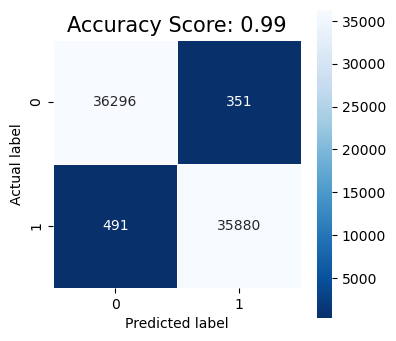

In [25]:
# K Nearest Neighbors
knn_y_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)
knn_f1 = f1_score(y_test, knn_y_pred)

knn_cm = confusion_matrix(y_test, knn_y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(knn_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.2f}'.format(knn_acc)
plt.title(all_sample_title, size = 15);
plt.savefig('./visuals/cf_knn.png')

print(knn_acc)
print(knn_precision)
print(knn_recall)
print(knn_f1)

0.8281793530362377
0.7919515721883195
0.8884550878447115
0.8374322958509343


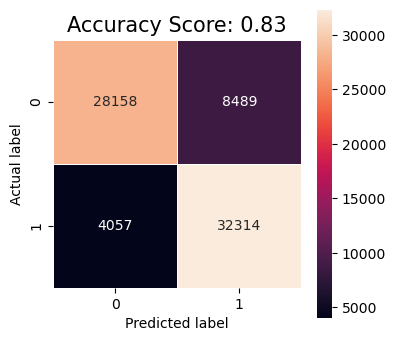

In [24]:
gb_y_pred = gnb.predict(X_test)
gb_acc = accuracy_score(y_test, gb_y_pred)
gb_precision = precision_score(y_test, gb_y_pred)
gb_recall = recall_score(y_test, gb_y_pred)
gb_f1 = f1_score(y_test, gb_y_pred)

gb_cm = confusion_matrix(y_test, gb_y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(gb_cm, annot=True, fmt=".0f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.2f}'.format(gb_acc)
plt.title(all_sample_title, size = 15);
plt.savefig('./visuals/cf_gb.png')

print(gb_acc)
print(gb_precision)
print(gb_recall)
print(gb_f1)